### Important notice : this notebook works under @rom1lebogoss conda env and not under @autoqchem conda env...

# Import tools

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') 

import sys
sys.path.append('../')
import dft_descriptors.fragmentation as fg

import gc
gc.collect()

4

# Load data

In [2]:
df = pd.read_csv('../data_csv/Data_test09032021.csv', sep = ',')

# Check if data is clean

In [3]:
for i in df["Product"]:
    m = Chem.MolFromSmiles(i,sanitize=False)
    if m is None:
          print('invalid', i)
            
for i in df["Reactant Smile (C-O)"]:
    m = Chem.MolFromSmiles(i,sanitize=False)
    if m is None:
          print('invalid', i)

# Generate fragments for the substrate on the C-O involved in the coupling 

In [4]:
unik_react = []
corr_product = []
for i, smi in enumerate(df["Reactant Smile (C-O)"]):
    can_smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi))
    if can_smi not in unik_react:
        unik_react.append(can_smi)
        corr_product.append(df["Product"][i])

fragC = []
fragO = []
for i in range(len(unik_react)):
    smi = unik_react[i]
    frag = fg.gen_frag_on_CO_break(unik_react[i], corr_product[i])
    if len(frag) > 1:
        fragC.append(frag[0])
        fragO.append(frag[1])
    elif len(frag) == 1:
        fragC.append(frag[0])
        fragO.append('nan')

# Generate the corresponding dataframe and a .csv 

In [5]:
df2 = pd.DataFrame(data={"react": unik_react, "fragC": fragC, "fragO": fragO, "product": corr_product})
#df2.to_csv("../data_csv/fragments.csv", sep=',',index=False)

# Visualise the different fragmentation in order to correct potentials errors

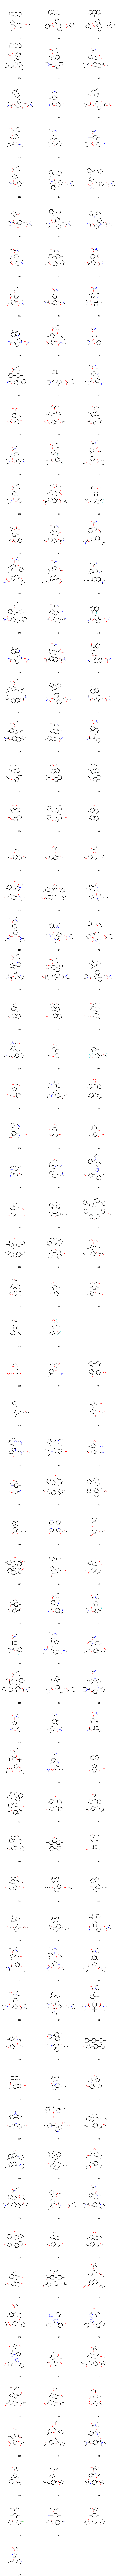

In [6]:
# better do it by slices of 200 molecules !
verif_mols = []
L=[str(i) for i in range(len(unik_react))]
for i in range(len(unik_react)):
    verif_mols.append(Chem.MolFromSmiles(str(unik_react[i]+"."+fragC[i]+"."+fragO[i])))
    
Draw.MolsToGridImage(verif_mols[200:], subImgSize=(400, 400), maxMols = 200, legends = L[200:])

###### an eventual manual correction can be done and fragment.csv can be updated
###### In this example molecules : 5, 31, 34, 57, 59, 89, 128, 164, 180, 222, 261 - 265, 269, 291 - 294, 301, 302, 306, 324, 334, 335, 349, 350, 351, 352, 356, 375, 376, 391

In [7]:
id_frags_to_modify = [5, 31, 34, 57, 59, 89, 128, 164, 180, 222, 261, 262, 263, 264, 
                      265, 269, 291, 292, 293, 294, 301, 302, 303, 306, 324, 334, 335, 349, 
                      350, 351, 352, 356, 375, 376, 391] 
df3 = pd.read_csv("../data_csv/fragments.csv", sep=',')

###### Rules are neaded to see if we keep some fragments or if we decide to remove them all, especially for the substrates undergoing a double coupling

In [8]:
df3.loc[57]

react      COc1nc(OC)nc(Oc2ccc(C3(c4ccc(Oc5nc(OC)nc(OC)n5...
fragC                                     *Oc1nc(OC)nc(OC)n1
fragO                                     *Oc1nc(OC)nc(OC)n1
product    O=C5OC(c2ccc(c1ccccc1)cc2)(c4ccc(c3ccccc3)cc4)...
Name: 57, dtype: object

###### Brute force method : remove all the wrong id 

In [9]:
df4 = df3.drop(index=id_frags_to_modify)
#df4.to_csv("../data_csv/fragments_corrected.csv", sep=',',index=False)